<a href="https://colab.research.google.com/github/obasekore/AI-bootCamp/blob/main/Astar_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import heapq

import numpy as np

from IPython.display import clear_output

import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
import matplotlib.lines as mlines

In [2]:
class GridEnvironment:
    def __init__(self, width, height):
        self.width = width
        self.height = height
        self.obstacles = []
        self.weights = {}

    def in_boundary(self, pose):
        #check if location is in boundary
        (x, y) = pose
        return 0 <= x < self.width and 0 <= y < self.height

    def passable(self, pose):
        return pose not in self.obstacles

    def neighbours(self, pose):
        # get the neighbour with obstacles and boundary filtered
        (x, y) = pose
        my_neigbours = [(x+1, y), (x, y-1), (x-1, y), (x, y+1)]
        # remove pose beyond boundary
        my_neigbours = filter(self.in_boundary, my_neigbours)
        # remove pose of obstacles
        my_neigbours = filter(self.passable, my_neigbours)

        return my_neigbours

    def cost(self, from_node, to_node):
        return self.weights.get(to_node, 1)

    def render(self, start=(0,0), goal=None, robot_pos=None, path = None, visited = [], move_robot=False):

        patches = []

        clear_output(wait=True)

        fig, ax = plt.subplots()

        # use top right corner as goal by default
        if goal is None:
             goal = (self.width - 1, self.height - 1)

        # put robot at start by default
        if robot_pos is None:
            robot_pos = list(start)

        colors = []

        xy = [[i,j] for i in range(self.width) for j in range(self.height)]

        copy_visited = visited

        # remove start and goal
        visited = list(visited)
        if start in visited: visited.pop(visited.index(start))
        if goal in visited: visited.pop(visited.index(goal))

        # Draw grid and color code
        for cnt in range(self.width*self.height):

            temp = [a_i - b_i for a_i, b_i in zip(xy[cnt], [0.5, 0.5])]
            rect = mpatches.Rectangle(temp, 0.9, 0.9, ec="None")
            patches.append(rect)

            # assign color to start, end, obstacles and empty grid
            if not tuple(xy[cnt]) in visited:
                if (list(start) == xy[cnt]):
                    colors.append(0.1)
                elif (list(goal) == xy[cnt]):
                    colors.append(0.2)
                elif (tuple(xy[cnt]) in self.obstacles):
                    colors.append(0.3)
                else:
                    colors.append(0.4)
            else:
                # assign color to visited grids
                colors.append(0.5)

        #robot location
        circle = mpatches.Circle(robot_pos, 0.4, ec="none")
        patches.append(circle)
        colors.append(0.6)

        collection = PatchCollection(patches)

        collection.set_array(np.array(colors))
        ax.add_collection(collection)

        # add a line i.e path to goal
        if not path is None:
            x, y = [i[0] for i in path],[i[1] for i in path]

            line = mlines.Line2D(x, y, lw=5., alpha=0.3, color='k')

            ax.add_line(line)

        plt.axis('equal')
        plt.axis('off')
        plt.tight_layout()

        plt.show()

        # animate moving robot to goal
        if (move_robot==True) and (not path is None):
            self.move_robot_to_goal(path)

    # loop through path to move robot to goal
    def move_robot_to_goal(self, path):
        for xy in path:
            self.render(start=path[0], goal=path[-1],robot_pos=xy, path=path)

In [3]:
class PriorityQueue:
    def __init__(self):
        self.elements = []

    def empty(self):
        return len(self.elements) == 0

    def put(self, item, priority):
        heapq.heappush(self.elements, (priority, item))

    def get(self):
        return heapq.heappop(self.elements)[1]

In [4]:
class a_star:

    def __init__(self, grid, start, goal, render=False, verbose=None):
        self.grid = grid
        self.start = start
        self.goal = goal
        self.render = render
        self.verbose = verbose

    def search(self):

        grid, start, goal = self.grid, self.start, self.goal

        ring = PriorityQueue()
        # pick a point ... a good place is the starting point... start_pose, 0-cost
        ring.put(start, 0)

        # initialize the visiting dictionary
        visiting_from = {}

        current_cost_incur = {}

        visiting_from[start] = None

        current_cost_incur[start] = 0

        while not ring.empty():
            # pick a point ... a
            current = ring.get()

            # if the point picked is not the END just pick another point
            if current == goal:
                break

            # visit the neighbours
            for next in grid.neighbours(current):

                # calculate cost of visiting neighbour
                new_cost = current_cost_incur[current] + grid.cost(current, next)

                # if not already visited and the cost is cheaper
                if next not in current_cost_incur or new_cost < current_cost_incur[next]:

                    # that's good point
                    current_cost_incur[next] = new_cost

                    # add optimistic heuristic cost
                    priority = new_cost + self.heuristic(goal, next)

                    ring.put(next, priority)
                    visiting_from[next] = current

                    if((self.render==True) and (not self.verbose is None)):
                        visited = visiting_from.keys()

                        grid.render(start=start, goal=goal, visited=visited)


        # get absolute path
        path=self.construct_absolute_path(visiting_from)
        # get visited locations
        visited = visiting_from.keys()

        if(self.render==True):
            grid.render(path=path, start=start, goal=goal, move_robot=True)

        return path, visited

    def heuristic(self, a, b):
        (x1, y1) = a
        (x2, y2) = b
        return abs(x1 - x2) + abs(y1 - y2)

    def construct_absolute_path(self, visiting_from):
        start, goal = self.start, self.goal
        current = goal

        path = []

        while current != start:

            path.append(current)

            current = visiting_from[current]

        path.append(start)

        path.reverse()

        return path

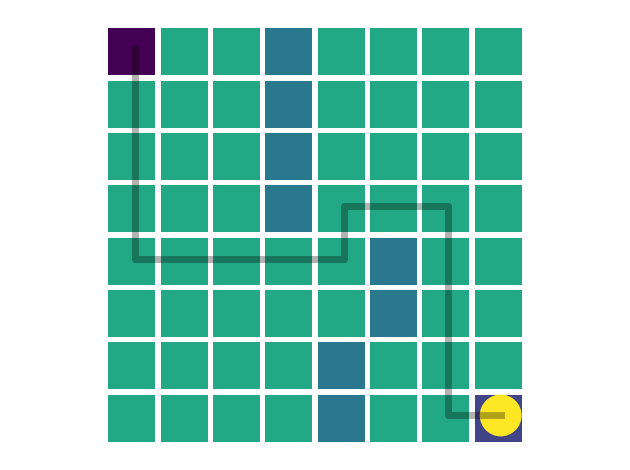

In [5]:
env = GridEnvironment(8, 8)
env.obstacles = [(3, 7), (3, 6), (3, 5), (3, 4), (4, 0), (4, 1), (5, 2), (5, 3)]

start, goal = (0, 7), (7, 0)

verbose = "high" # show step by step node visit

a_star_s = a_star(env, start, goal, render=True, verbose = verbose)
path, visited = a_star_s.search()


# env.render(path=path, start=start, goal=goal, move_robot=True, visited=visited)
